In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

import time
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import callbacks
from keras import losses


## Funzione per ridurre l'uso della memoria

In [2]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df


# Caricamento e preprocessing del Dataset
import dei datset per il training e per il test

X_train contiene i soli campioni benigni

y_train contiene solo etichette benigne

X_test contiene solo le feature

y_test contiene solo le etichette

In [3]:
# Caricamento dei dati per il training e il test
train_df = pd.read_csv('../archive/training_set3_processed.csv')
test_df = pd.read_csv('../archive/test_set3_processed.csv')
# Applicazione della funzione per ridurre l'uso della memoria
train_df = reduce_memory_usage(train_df)
test_df = reduce_memory_usage(test_df)

# Separa le feature e le label per training e test
# X_train contiene solo i campioni benigni
X_train = train_df[train_df['target'] == 0].drop(columns=['target'])

X_train.to_csv('../archive/train_b.csv', index=False)

# Crea y_train contenente solo le etichette (tutti 0)
y_train = train_df[train_df['target'] == 0]['target'].to_numpy() 

X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

print(X_train.shape, X_test.shape, X_train.shape[0] + X_test.shape[0])

(8444945, 43) (2402405, 43) 10847350


In [4]:
X_train.shape

(8444945, 43)

In [5]:
X_test.shape

(2402405, 43)

In [6]:
y_train.shape

(8444945,)

In [7]:
y_test.shape

(2402405,)

## Split del training in training e validation

In [8]:
# split train -> train_t + validation dataset
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [9]:
print(X_train_t.shape,X_val.shape,X_train.shape)

(6755956, 43) (1688989, 43) (8444945, 43)


In [10]:
# Inserisci le etichette nel DataFrame X_test
X_test.insert(X_test.shape[1], 'target', y_test, True)

print(X_test.shape)
X_test_b = X_test.drop(X_test[X_test['target'] == 1].index)  # Solo campioni benigni

X_test_a = X_test.drop(X_test[X_test['target'] == 0].index)  # Solo campioni maligni

# Rimozione della colonna 'target' da X_test_a
X_test_a = X_test_a.drop(['target'], axis=1)

# Rimozione della colonna 'target' da X_test_b
X_test_b = X_test_b.drop(['target'], axis=1)

# Rimozione della colonna 'target' da X_test
X_test = X_test.drop(['target'], axis=1)


(2402405, 44)


In [11]:
print(X_test.shape, X_test_a.shape,X_test_b.shape)

(2402405, 43) (291004, 43) (2111401, 43)


In [12]:
n_features = X_train.shape[1]
print(n_features)

43


Epoch 1/50
211124/211124 [==============================] - 541s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 8.7110e-04 - val_mean_squared_error: 8.7110e-04
Epoch 2/50
211124/211124 [==============================] - 549s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 7.8769e-04 - val_mean_squared_error: 7.8769e-04
Epoch 3/50
211124/211124 [==============================] - 549s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 7.3188e-04 - val_mean_squared_error: 7.3188e-04
Epoch 4/50
211124/211124 [==============================] - 549s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 8.0839e-04 - val_mean_squared_error: 8.0839e-04
Epoch 5/50
211124/211124 [==============================] - 555s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.9477e-04 - val_mean_squared_error: 6.9477e-04
Epoch 6/50
211124/211124 [==============================] - 554s 3ms/step - loss: 0.0011 - mean_squared_error:

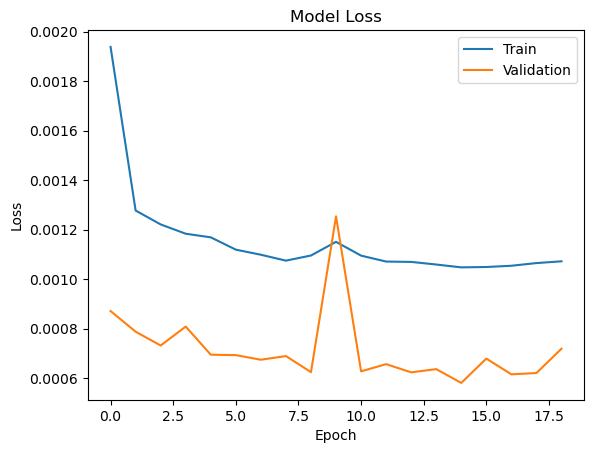

In [13]:
# model

n_features = X_train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation='relu', input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation='relu'))
encoder.add(layer=layers.Dense(units=5, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation='relu', input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation='relu'))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss='MSE', optimizer='adam', metrics='mean_squared_error')

# train model

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = autoencoder.fit(x=X_train_t, y=X_train_t, epochs=50, verbose=1, validation_data=[X_val, X_val], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
autoencoder.summary()
models.save_model(autoencoder, '../archive/model3')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 5)                 1145      
                                                                 
 decoder (Sequential)        (None, 43)                1183      
                                                                 
Total params: 2,328
Trainable params: 2,328
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ../archive/model3\assets
